In [1]:
# Dependencies
# sktime: 0.9.0
# scikit-learn: 0.24.2
# numpy: 1.19.3
# pandas 1.1.5
# joblib: 1.1.0

import matplotlib.pyplot as plt
from math import sqrt
import numpy as np
import pandas as pd
import csv

# for data split and evaluate the model
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sktime.utils.slope_and_trend import _slope

# construct time series random forest classifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sktime.classification.compose import ComposableTimeSeriesForestClassifier

import joblib

In [2]:
X = []
y = []

In [3]:
for i in range(2, 8):
    path = "./data/formatData/Data" + str(i) + '.csv'
    with open(path, newline='') as csvFile:
        rows = csv.reader(csvFile)
        for row in rows:
            # load XYZ train data
            arrX = np.array(row[0][1:-1].split(', ')).astype(np.float)
            arrY = np.array(row[1][1:-1].split(', ')).astype(np.float)
            arrZ = np.array(row[2][1:-1].split(', ')).astype(np.float)
            # cal relative acceleration
            vibrate = []
            for j in range(1, arrX.size):
                acc = sqrt((arrX[j] - arrX[j-1])**2 + (arrY[j] - arrY[j-1])**2 + (arrZ[j] - arrZ[j-1])**2)*100
                vibrate.append(acc)
            X.append([pd.Series(vibrate)])
            if int(row[3]) == 2:
                y.append('0~2')
            else:
                y.append(row[3])

In [4]:
random_state_num = 49

In [5]:
X = pd.DataFrame(X)
y = pd.Series(y)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.125, random_state=random_state_num, stratify=y)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1049, 1) (1049,) (150, 1) (150,)


In [7]:
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

['0~2' '3' '4' '5' '6' '7'] [178 172 176 173 178 172]


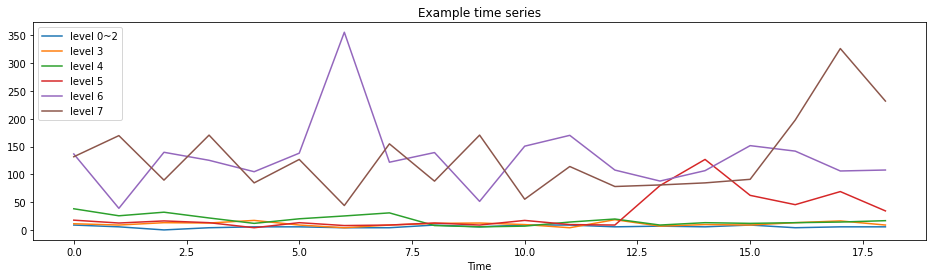

In [8]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    picture = X_train.loc[y_train == label, 0].iloc[10]
    if label==2:
        label=f"0~2"
        
    picture.plot(ax=ax, label=f"level {label}")
plt.legend()
ax.set(title="Example time series", xlabel="Time");

In [9]:
# construct decisionTree for randomforest
steps = [
    (
        "extract",
        RandomIntervalFeatureExtractor(
            n_intervals="sqrt", features=[np.mean, np.std, _slope]
        ),
    ),
    ("clf", DecisionTreeClassifier()),
]
time_series_tree = Pipeline(steps)

In [10]:
# construct a Time Series Forest Classifier
tsf = ComposableTimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=150,
    bootstrap=True,
    oob_score=True,
    random_state=random_state_num,
    n_jobs=-1,
)

In [11]:
X_train, y_train = shuffle(X_train, y_train, random_state=random_state_num)
print(X_train.shape, y_train.shape)
scores = cross_val_score(tsf, X_train, y_train, scoring="accuracy", cv=7)
print(scores.mean())

(1049, 1) (1049,)
0.8017002237136465


In [12]:
tsf.fit(X_train, y_train)

ComposableTimeSeriesForestClassifier(bootstrap=True,
                                     estimator=Pipeline(steps=[('extract',
                                                                RandomIntervalFeatureExtractor(features=[<function mean at 0x000002BEFE34CA60>,
                                                                                                         <function std at 0x000002BEFE34CBF8>,
                                                                                                         <function _slope at 0x000002BEA1547C80>])),
                                                               ('clf',
                                                                DecisionTreeClassifier())]),
                                     n_estimators=150, n_jobs=-1,
                                     oob_score=True, random_state=49)

In [13]:
y_pred = tsf.predict(X_valid)
# f1_score(y_valid, y_pred, average="weighted")
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0~2       0.85      0.88      0.86        25
           3       0.76      0.76      0.76        25
           4       0.91      0.84      0.87        25
           5       0.75      0.84      0.79        25
           6       0.73      0.64      0.68        25
           7       0.85      0.88      0.86        25

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.81      0.81      0.81       150



In [14]:
print(accuracy_score(y_valid, y_pred))

0.8066666666666666


In [15]:
valid_predict = np.array(y_pred)
valid_reality = np.array(y_valid)

In [16]:
joblib.dump(tsf, 'modelwithML')

['modelwithML']